In [41]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

# I/ Functional toy data (lip dataset)

### Load

In [42]:
tgrid = np.squeeze(pd.read_csv(os.getcwd() + "/data/t.csv", header=None).values)
x = pd.read_csv(os.getcwd() + "/data/x.csv", header=None).values
y = pd.read_csv(os.getcwd() + "/data/y.csv", header=None).values

### Show examples

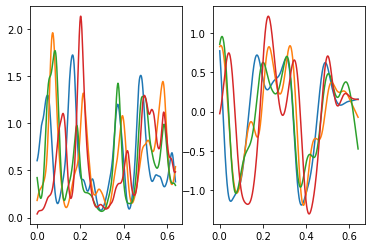

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(tgrid, x[:, :4])
ax[1].plot(tgrid, y[:, :4])
plt.show()

### Preprocessing

In [4]:
x = x.T
n = x.shape[0]
ntest = 4
ntrain = n - ntest
xtrain, xtest = x[:ntrain], x[ntrain:]
ytrain = ([tgrid for i in range(ntrain)], [y[:, i] for i in range(ntrain)])
ytest = ([tgrid for i in range(ntest)], [y[:, i] for i in range(ntest)])

### Indexing example

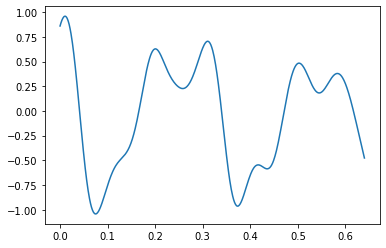

In [44]:
# Plot the i-th output function 
i = 2
plt.plot(ytrain[0][i], ytrain[1][i])
plt.show()

# II/ Functional regressions

## 1/ Kernel projection learning (KPL)

### Import package

In [5]:
# Import kernel_projection_learning module 
# Replace with location of package on computer
sys.path.append("/home/dimitri/Desktop")
from pyfuncreg.functional_regressors import kernels, kernel_projection_learning as kpl

### Chose dictionary and output matrix

In [6]:
# Domain of the output functions
domain = np.array([[tgrid[0], tgrid[-1]]])
# Fourier basis parameters
nfreqs = 10
output_basis = ("fourier", {"lower_freq": 0, "upper_freq": nfreqs, "domain": domain})
# Output matrix
output_matrix = ("eye", {})

### Chose kernel

In [7]:
ker_sigma = 15
gauss_ker = kernels.GaussianScalarKernel(ker_sigma, normalize=False)

### Instantiate regressor and fit it

In [8]:
# Instantiate regressor
reg_kpl = kpl.SeperableKPL(regu=0.5, 
                           kernel=gauss_ker, 
                           B=output_matrix, 
                           basis_out=output_basis, 
                           center_output=False)
# Fit regressor
reg_kpl.fit(xtrain, ytrain)

### Predictions on test set

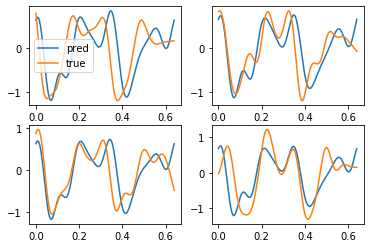

In [9]:
# Predict on test set
ypred = reg_kpl.predict_evaluate(xtest, tgrid)

# Plot predictions
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    row = i//2
    col = i%2
    ax[row, col].plot(tgrid, ypred[i], label="pred")
    ax[row, col].plot(tgrid, ytest[1][i], label="true")
ax[0, 0].legend()
plt.show()

### Using data-dependant dictionary (FPCA)

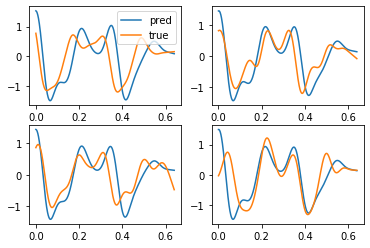

In [45]:
output_basis = ("functional_pca", {"n_basis": 20, "input_dim": 1, "n_evals": 600, "domain": domain})

# Instantiate kernel projection learning regressor
reg_kpl_fpca = kpl.SeperableKPL(regu=0.5, 
                                kernel=gauss_ker, 
                                B=output_matrix, 
                                basis_out=output_basis, 
                                center_output=True)

# Fit regressor
reg_kpl_fpca.fit(xtrain, ytrain)

# Predict
ypred = reg_kpl_fpca.predict_evaluate(xtest, tgrid)

# Plot predictions
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    row = i//2
    col = i%2
    ax[row, col].plot(tgrid, ypred[i], label="pred")
    ax[row, col].plot(tgrid, ytest[1][i], label="true")
ax[0, 0].legend()
plt.show()

### Sparsely sampled output functions

ValueError: x and y must have same first dimension, but have shapes (641,) and (32,)

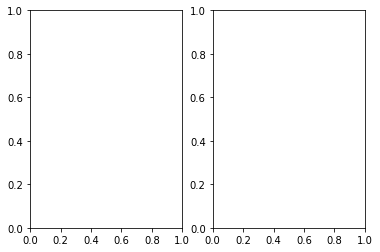

In [46]:
from pyfuncreg.data import degradation

# Add noise and downsample output functions at random locations
ytrain_deg = degradation.downsample_output(ytrain, 0.8, seed=456)
ytrain_deg = degradation.add_noise_outputs(ytrain_deg, 0.1, seed=567)

# Plot examples of degraded data
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(4):
    ax[0].plot(tgrid, x[i])
    ax[1].scatter(ytrain_deg[0][i], ytrain_deg[1][i])
plt.show()

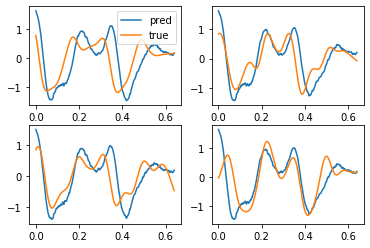

In [22]:
# Fit regressor
reg_kpl.fit(xtrain, ytrain_deg)

# Predict on test set
ypred = reg_kpl.predict_evaluate(xtest, tgrid)

# Plot predictions
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    row = i//2
    col = i%2
    ax[row, col].plot(tgrid, ypred[i], label="pred")
    ax[row, col].plot(tgrid, ytest[1][i], label="true")
ax[0, 0].legend()
plt.show()

## 2/ Functional kernel ridge regression (FKRR)

### Import package

In [104]:
from pyfuncreg.functional_regressors import ovkernel_ridge as ovkr

### Chose input and output kernels

In [150]:
# Input kernel
kerin_sigma = 15
gauss_kerin = kernels.GaussianScalarKernel(kerin_sigma, normalize=False)

# Output kernel
kerout_sigma = 0.05
lap_kerout = kernels.LaplaceScalarKernel(kerout_sigma, normalize=False)

### Instantiate regressor and fit it

In [152]:
# Instantiate regressor
reg_fkrr = ovkr.SeparableOVKRidgeFunctional(regu=0.01,
                                            kernel_in=gauss_kerin, 
                                            kernel_out=lap_kerout, 
                                            approx_locs=tgrid, 
                                            center_output=False)

# Fit regressor
reg_fkrr.fit(xtrain, ytrain)

### Prediction on test set

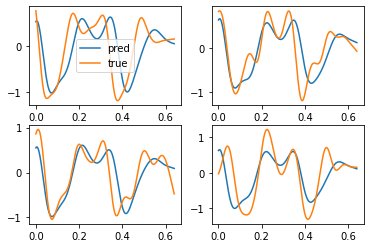

In [153]:
# Predict on test set
ypred = reg_fkrr.predict_evaluate(xtest, tgrid)

# Plot predictions
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    row = i//2
    col = i%2
    ax[row, col].plot(tgrid, ypred[i], label="pred")
    ax[row, col].plot(tgrid, ytest[1][i], label="true")
ax[0, 0].legend()
plt.show()

## 3/ Triple basis estimator

In [23]:
from pyfuncreg.functional_regressors import triple_basis as tripbas

### Represent input data as functions

In [24]:
xtrain_func = ([tgrid for i in range(ntrain)], [x[i] for i in range(ntrain)])
xtest_func = ([tgrid for i in range(ntest)], [x[i] for i in range(ntest)])

### Define input and output bases

In [37]:
# Domain of the intput and output functions (different domains are supported)
domain = np.array([[tgrid[0], tgrid[-1]]])
# Input Fourier basis parameters
nfreqs_in = 20
input_basis = ("fourier", {"lower_freq": 0, "upper_freq": nfreqs_in, "domain": domain})
# Output Fourier basis parameters
nfreqs_out = 10
output_basis = ("fourier", {"lower_freq": 0, "upper_freq": nfreqs_out, "domain": domain})

### Instantiate random Fourier features approximation basis

In [38]:
rffs_basis = ("random_fourier", {"n_basis": 100, "domain": domain, 
                                 "bandwidth": 10, "input_dim":1, 
                                 "seed": 432, "compute_gram":False})

### Instantiate regressor and fit it

In [39]:
# Instantiate regressor
reg_3be = tripbas.TripleBasisEstimator(regu=0.5, 
                                        basis_in=input_basis,
                                        basis_rffs=rffs_basis,
                                        basis_out=output_basis, 
                                        center_output=False)

# Fit regressor
reg_3be.fit(xtrain_func, ytrain)

### Prediction on test set

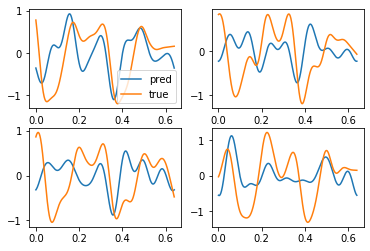

In [40]:
# Predict on test set
ypred = reg_3be.predict_evaluate(xtest_func, tgrid)

# Plot predictions
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(4):
    row = i//2
    col = i%2
    ax[row, col].plot(tgrid, ypred[i], label="pred")
    ax[row, col].plot(tgrid, ytest[1][i], label="true")
ax[0, 0].legend()
plt.show()